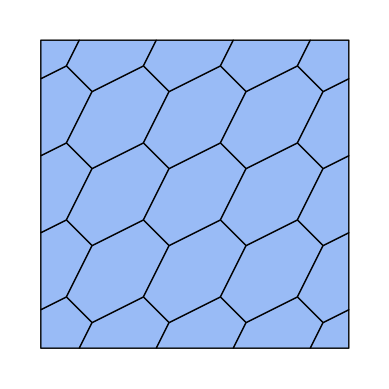

In [1]:

import numpy as np

from fealpy.mesh.polygon_mesh import PolygonMesh
from poisson_model import SinSinData, ExpSinData, CosCosData
from mimetic_solver import Mimetic

pde = SinSinData()
ns = 4
mesh = PolygonMesh.from_unit_square(nx=ns, ny=ns)

import matplotlib.pyplot as plt
fig = plt.figure()
axes = fig.gca()
mesh.add_plot(axes)
plt.show()


The 0-th computation:
NC: 25
NE: 88
NN: 64
$|| p - p_h ||_{\Omega, 0}$
[0.00690396 0.         0.         0.         0.        ]
------
$|| p - p_h||_{\Omega, \infty}$
[0.01837223 0.         0.         0.         0.        ]
------
The 1-th computation:
NC: 81
NE: 272
NN: 192
$|| p - p_h ||_{\Omega, 0}$
[0.00690396 0.00179947 0.         0.         0.        ]
------
$|| p - p_h||_{\Omega, \infty}$
[0.01837223 0.00540833 0.         0.         0.        ]
------
The 2-th computation:
NC: 289
NE: 928
NN: 640
$|| p - p_h ||_{\Omega, 0}$
[0.00690396 0.00179947 0.00043736 0.         0.        ]
------
$|| p - p_h||_{\Omega, \infty}$
[0.01837223 0.00540833 0.00176059 0.         0.        ]
------
The 3-th computation:
NC: 1089
NE: 3392
NN: 2304
$|| p - p_h ||_{\Omega, 0}$
[0.00690396 0.00179947 0.00043736 0.00010375 0.        ]
------
$|| p - p_h||_{\Omega, \infty}$
[0.01837223 0.00540833 0.00176059 0.00050037 0.        ]
------
The 4-th computation:
NC: 4225
NE: 12928
NN: 8704
$|| p - p_h ||_

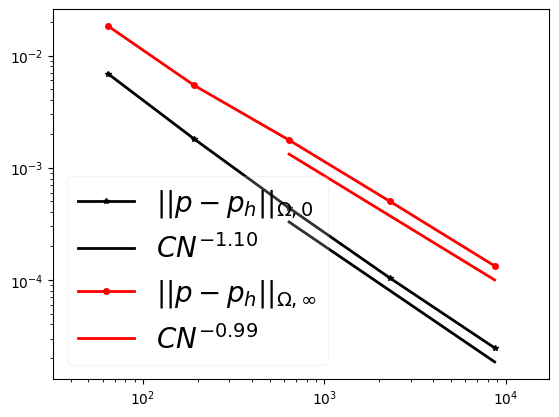

In [2]:
pde = ExpSinData()
ns = 4
mesh = PolygonMesh.from_unit_square(nx=ns, ny=ns)

maxit = 5
errorType = ['$|| p - p_h ||_{\\Omega, 0}$',
             '$|| p - p_h||_{\\Omega, \\infty}$']
errorMatrix = np.zeros((2, maxit), dtype=np.float64)
nDof = np.zeros(maxit, dtype=np.int_)

for iter in range(maxit):
    print("The {}-th computation:".format(iter))
    NC = mesh.number_of_cells()
    print("NC:", NC)
    NE = mesh.number_of_edges()
    print("NE:", NE)
    NN = mesh.number_of_nodes()
    print("NN:", NN)
    eDdof = mesh.ds.boundary_edge_index()
    nDdof = mesh.entity('edge')[eDdof][:, 0]

    solver = Mimetic(mesh)

    MV = solver.gmv()

    ME = solver.gme()

    grad_h = solver.grad_operator()

    A = grad_h.T @ ME @ grad_h

    node = mesh.entity('node')
    p = pde.solution(node)

    node = mesh.entity('node')
    rhs = pde.source(node)
    ph = np.zeros(NN)

    ph[nDdof] = pde.solution(node[nDdof])
    b = MV @ rhs
    b = b - A @ ph

    bdIdx = np.zeros(A.shape[0], dtype=np.int_)
    bdIdx[nDdof.flat] = 1
    from scipy.sparse import spdiags
    D0 = spdiags(1-bdIdx, 0, A.shape[0], A.shape[0]).toarray()
    D1 = spdiags(bdIdx, 0, A.shape[0], A.shape[0]).toarray()
    A = D0 @ A @ D0 + D1

    b[nDdof] = pde.Dirichlet(node[nDdof])

    ph = np.linalg.solve(A, b)

    # l2 误差
    errorMatrix[0, iter] = np.sqrt( np.sum( np.abs(p - ph)**2 ) * 1/NN )
    # l_infty 误差
    errorMatrix[1, iter] = np.max( np.abs(p - ph))

    if iter < maxit-1:
        ns = ns*2
        mesh = PolygonMesh.from_unit_square(nx=ns, ny=ns)

    for i, errType in enumerate(errorType):
        print(errType)
        print(errorMatrix[i])
        print('------')
        nDof[iter] = NN

print("errorMatrix:\n", errorMatrix)

from fealpy.tools.show import showmultirate

showmultirate(plt, 2, nDof, errorMatrix, errorType, propsize=20, lw=2, ms=4)
plt.show()

convergence_rates:
 [[1.93985375 2.04066423 2.07572897 2.06772011]
 [1.76427126 1.6191263  1.81500332 1.90994282]]


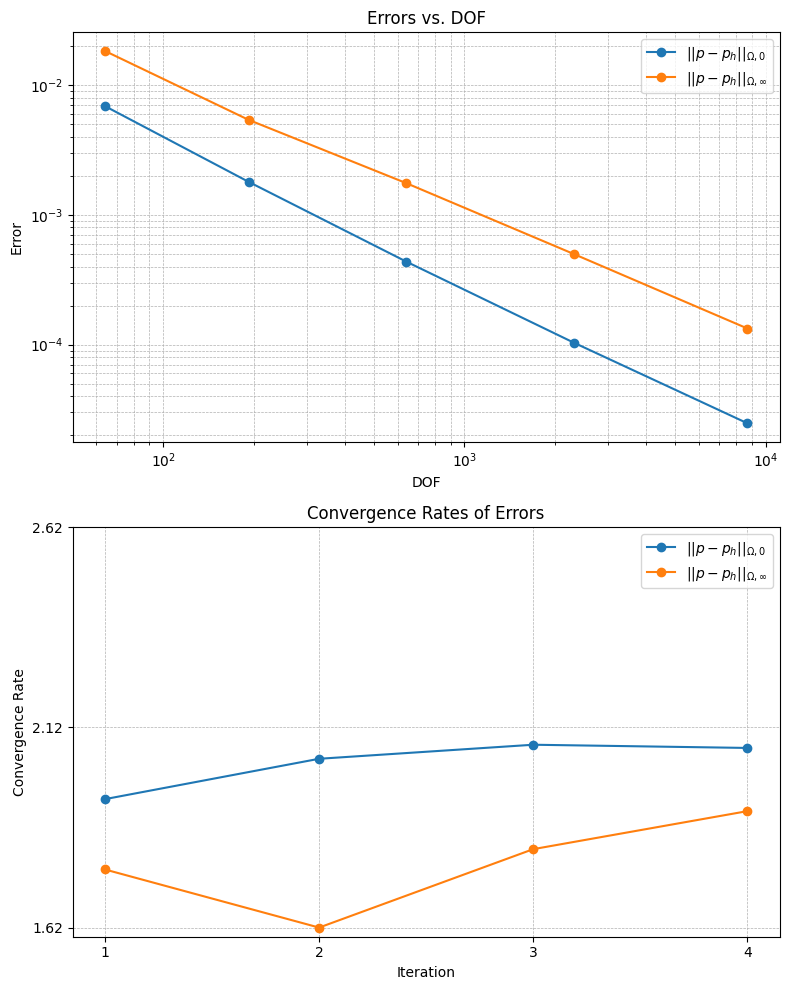

In [3]:

# Compute error convergence rates
ratios = errorMatrix[:, 0:-1] / errorMatrix[:, 1:]
convergence_rates = np.log2(ratios)
print("convergence_rates:\n", convergence_rates)

# Create a plotting window with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Subplot 1: Plotting the errors
x_dof = nDof
for i, errType in enumerate(errorType):
    axes[0].loglog(x_dof, errorMatrix[i], '-o', label=errType)
axes[0].set_xlabel('DOF')
axes[0].set_ylabel('Error')
axes[0].set_title('Errors vs. DOF')
axes[0].legend()
axes[0].grid(True, which="both", ls="--", linewidth=0.5)

# Subplot 2: Plotting the convergence rates
x = np.arange(1, maxit)
for i, errType in enumerate(errorType):
    axes[1].plot(x, convergence_rates[i], '-o', label=errType)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Convergence Rate')
axes[1].set_title('Convergence Rates of Errors')
axes[1].legend()
axes[1].grid(True, which="both", ls="--", linewidth=0.5)
plt.xticks(x)
plt.yticks(np.arange(np.min(convergence_rates), np.max(convergence_rates)+1, step=0.5))

plt.tight_layout()
plt.show()
